In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline, make_union, Pipeline
from sklearn.compose import make_column_selector, make_column_transformer, ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import learning_curve
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [2]:
pd.set_option('display.max_columns', None)  
pd.set_option('display.width', None)
data = pd.read_csv("train_titanic.csv")
df = data.copy()
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
df.shape

(891, 12)

In [4]:
df = df.drop(["Cabin", "Name", "Ticket", "PassengerId"], axis=1)

In [5]:
y = df["Survived"]
df = df.drop("Survived", axis=1)

In [6]:
df["Family"] = df["SibSp"].values + df["Parch"].values

<Axes: >

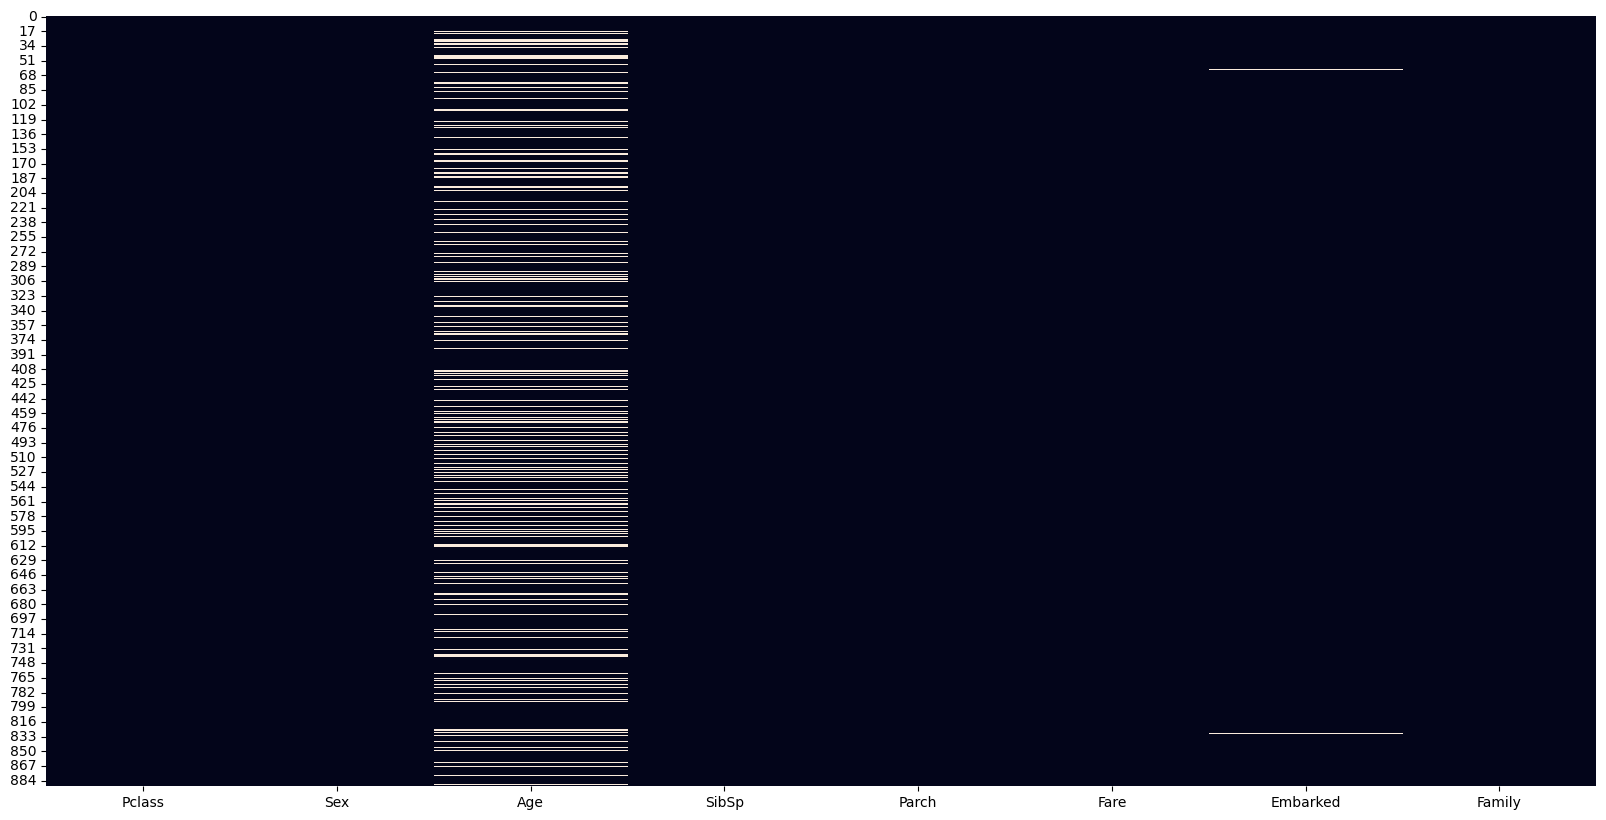

In [7]:
plt.figure(figsize=(20,10))
sns.heatmap(df.isna(),cbar=False)

In [8]:
df.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Family
0,3,male,22.0,1,0,7.2500,S,1
1,1,female,38.0,1,0,71.2833,C,1
2,3,female,26.0,0,0,7.9250,S,0
3,1,female,35.0,1,0,53.1000,S,1
4,3,male,35.0,0,0,8.0500,S,0


In [9]:
X_train, X_test, y_train, y_test = train_test_split(df, y, random_state=0)

In [10]:
categorical_features = ["Pclass", "Sex", "SibSp", "Parch", "Embarked"]
numerical_features = ["Age", "Fare"]

numerical_pipeline = make_pipeline(SimpleImputer(strategy="constant", fill_value=-1),
                                   StandardScaler())
categorical_pipeline = make_pipeline(SimpleImputer(strategy = "most_frequent"),
                                     OneHotEncoder(handle_unknown='ignore'))
preprocessor = make_column_transformer((numerical_pipeline, numerical_features),
                       (categorical_pipeline, categorical_features))

In [11]:
def evaluation(model):

    model.fit(X_train, y_train)
    ypred = model.predict(X_test)

    print(confusion_matrix(y_test, ypred))
    print(classification_report(y_test, ypred))
    
    
    N, train_score, val_score = learning_curve(model, X_train, y_train,
                                              cv=4, scoring='f1',
                                               train_sizes=np.linspace(0.1, 1, 10))
    
    
    plt.figure(figsize=(12, 8))
    plt.plot(N, train_score.mean(axis=1), label='train score')
    plt.plot(N, val_score.mean(axis=1), label='validation score')
    plt.legend()

In [12]:

RandomForest = make_pipeline(preprocessor, RandomForestClassifier(random_state=0))

AdaBoost = make_pipeline(preprocessor, AdaBoostClassifier(random_state=0, algorithm='SAMME'))

SVM = make_pipeline(preprocessor, SVC(random_state=0))

KNN = make_pipeline(preprocessor, KNeighborsClassifier())

DTC = make_pipeline(preprocessor, DecisionTreeClassifier(random_state=0))

GB = make_pipeline(preprocessor, GradientBoostingClassifier(random_state=0))

In [13]:
dict_of_models = {"RandomForest": RandomForest,
                  "AdaBoost":AdaBoost,
                  "SVM":SVM,
                  "KNN":KNN,
                  "DTC":DTC,
                  "GB":GB}

RandomForest
[[124  15]
 [ 25  59]]
              precision    recall  f1-score   support

           0       0.83      0.89      0.86       139
           1       0.80      0.70      0.75        84

    accuracy                           0.82       223
   macro avg       0.81      0.80      0.80       223
weighted avg       0.82      0.82      0.82       223

AdaBoost
[[114  25]
 [ 24  60]]
              precision    recall  f1-score   support

           0       0.83      0.82      0.82       139
           1       0.71      0.71      0.71        84

    accuracy                           0.78       223
   macro avg       0.77      0.77      0.77       223
weighted avg       0.78      0.78      0.78       223

SVM
[[123  16]
 [ 27  57]]
              precision    recall  f1-score   support

           0       0.82      0.88      0.85       139
           1       0.78      0.68      0.73        84

    accuracy                           0.81       223
   macro avg       0.80      0.78

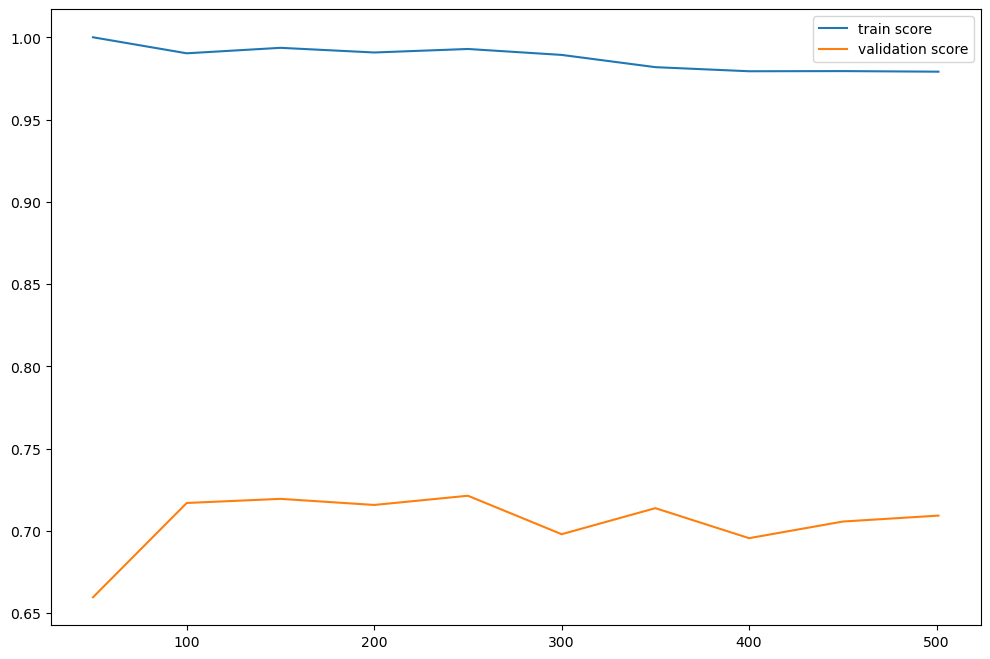

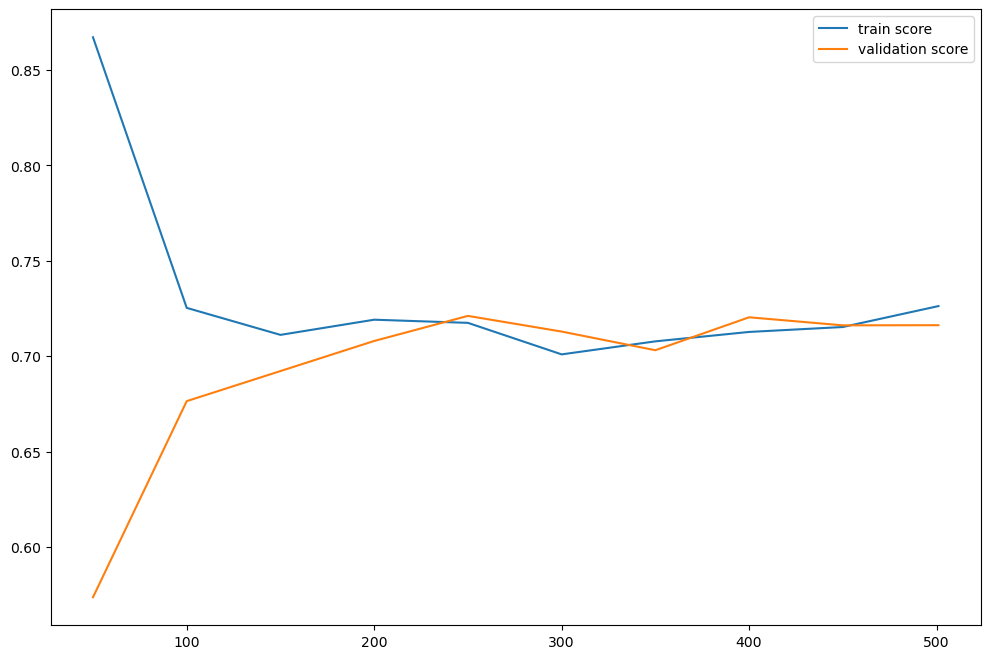

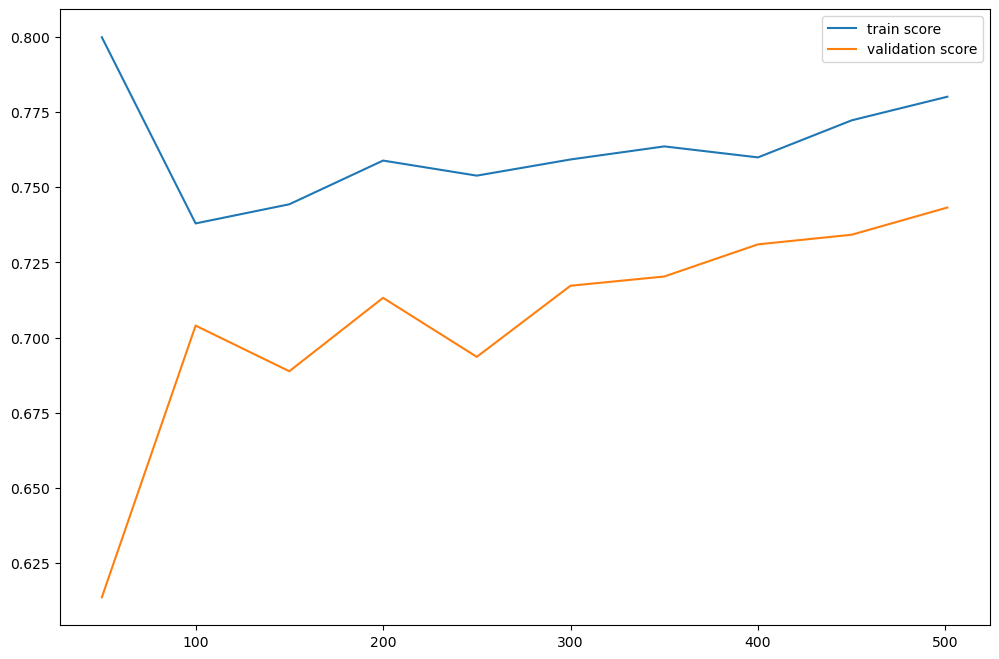

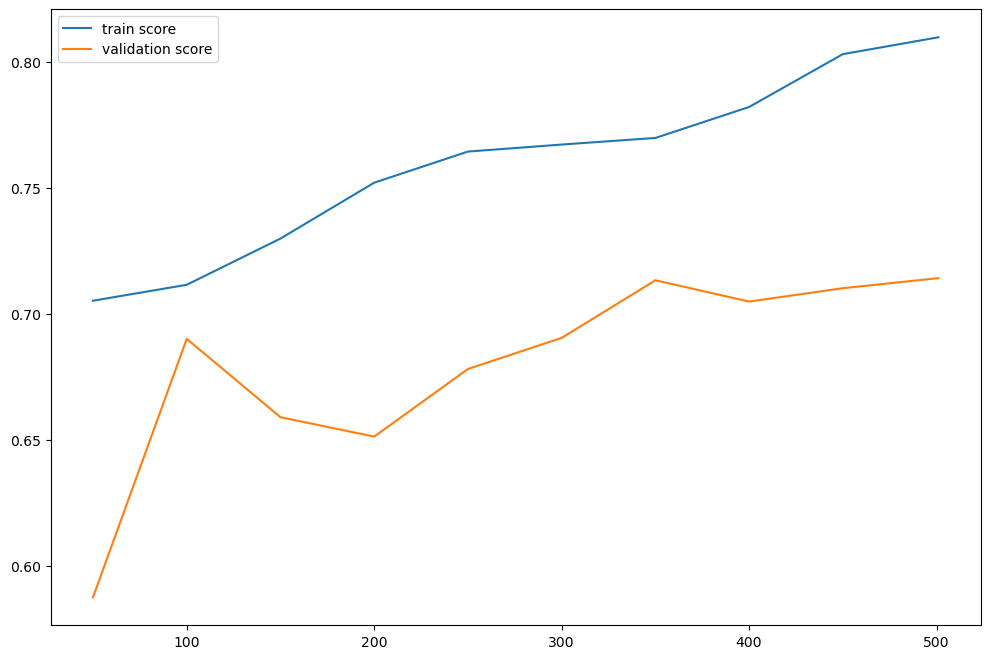

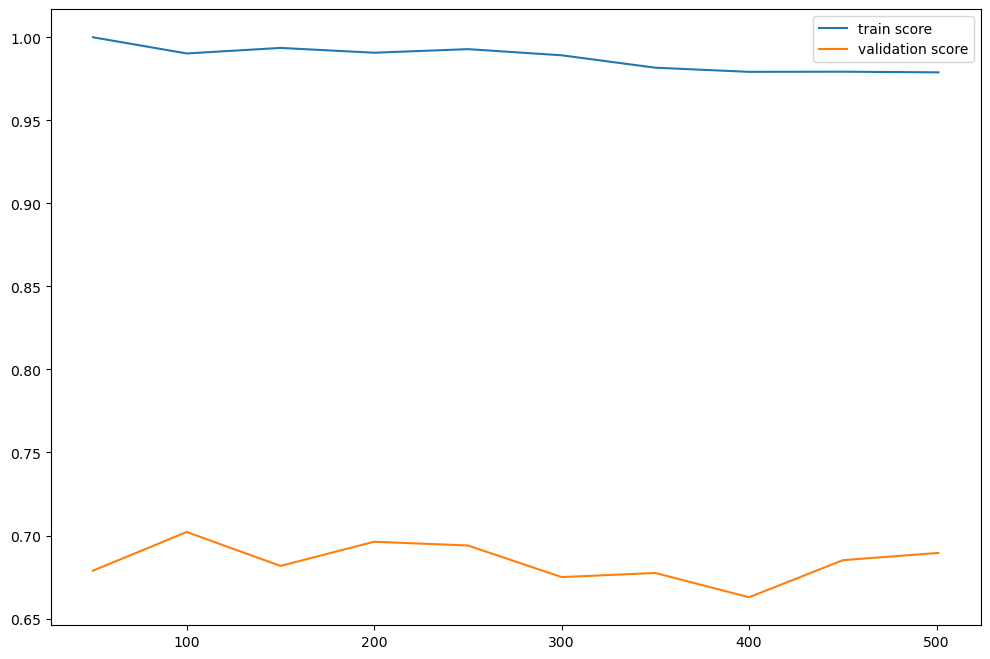

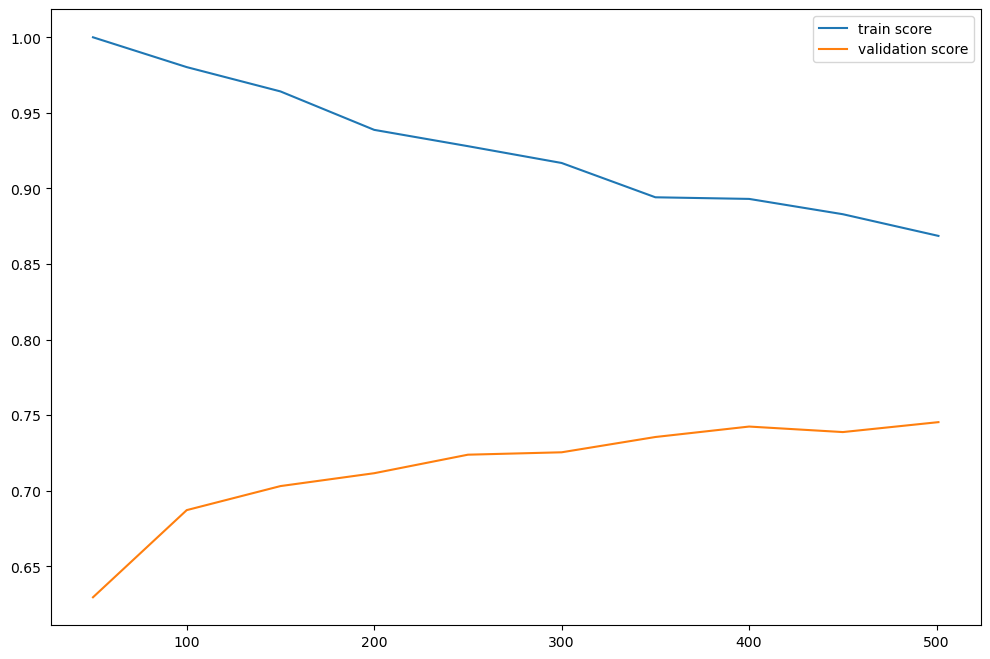

In [14]:
for name, model in dict_of_models.items():

    print(name)
    evaluation(model)

In [15]:
GB = make_pipeline(preprocessor, 
                             SelectKBest(f_classif, k=4),
                             GradientBoostingClassifier(random_state=0))

In [16]:
print("Pipeline Details:\n")

# Boucle pour afficher chaque étape avec ses paramètres
for step_name, step in GB.named_steps.items():
    print(f"Step: {step_name}")
    print(f"Type: {type(step).__name__}")
    print("Params:")
    
    # Formatage des paramètres
    params = step.get_params()
    for param_name, param_value in params.items():
        print(f"  - {param_name}: {param_value}")
    
    print("\n" + "-"*50 + "\n")

Pipeline Details:

Step: columntransformer
Type: ColumnTransformer
Params:
  - n_jobs: None
  - remainder: drop
  - sparse_threshold: 0.3
  - transformer_weights: None
  - transformers: [('pipeline-1', Pipeline(steps=[('simpleimputer',
                 SimpleImputer(fill_value=-1, strategy='constant')),
                ('standardscaler', StandardScaler())]), ['Age', 'Fare']), ('pipeline-2', Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='most_frequent')),
                ('onehotencoder', OneHotEncoder(handle_unknown='ignore'))]), ['Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked'])]
  - verbose: False
  - verbose_feature_names_out: True
  - pipeline-1: Pipeline(steps=[('simpleimputer',
                 SimpleImputer(fill_value=-1, strategy='constant')),
                ('standardscaler', StandardScaler())])
  - pipeline-2: Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='most_frequent')),
                ('onehotencoder', OneHotEncoder(handle_unknown='ignore'))])
  - pi

In [17]:
hyper_params = {
                "selectkbest__k" : [4, 5, 6],
                "gradientboostingclassifier__n_estimators": [100, 150, 200],
                "gradientboostingclassifier__learning_rate": [0.1, 0.5, 1],
                "gradientboostingclassifier__max_depth": [3, 4],
                "gradientboostingclassifier__min_samples_split": [5],
                "gradientboostingclassifier__min_samples_leaf" : [1, 2],
                "gradientboostingclassifier__subsample" : [0.7, 0.8, 0.9, 1.0],
                "gradientboostingclassifier__ccp_alpha" : [0.001, 0.01],
                "gradientboostingclassifier__random_state" : [0]
}

In [18]:
grid = RandomizedSearchCV(GB, hyper_params, scoring="f1", cv=5, n_iter=1000)
grid.fit(X_train, y_train)
print(grid.best_params_)
y_pred = grid.predict(X_test)
print(classification_report(y_test, y_pred))

l:\Anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:318: UserWarning: The total space of parameters 864 is smaller than n_iter=1000. Running 864 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


{'selectkbest__k': 5, 'gradientboostingclassifier__subsample': 0.8, 'gradientboostingclassifier__random_state': 0, 'gradientboostingclassifier__n_estimators': 100, 'gradientboostingclassifier__min_samples_split': 5, 'gradientboostingclassifier__min_samples_leaf': 1, 'gradientboostingclassifier__max_depth': 3, 'gradientboostingclassifier__learning_rate': 1, 'gradientboostingclassifier__ccp_alpha': 0.001}
              precision    recall  f1-score   support

           0       0.85      0.87      0.86       139
           1       0.78      0.75      0.76        84

    accuracy                           0.83       223
   macro avg       0.81      0.81      0.81       223
weighted avg       0.82      0.83      0.82       223



[[121  18]
 [ 21  63]]
              precision    recall  f1-score   support

           0       0.85      0.87      0.86       139
           1       0.78      0.75      0.76        84

    accuracy                           0.83       223
   macro avg       0.81      0.81      0.81       223
weighted avg       0.82      0.83      0.82       223



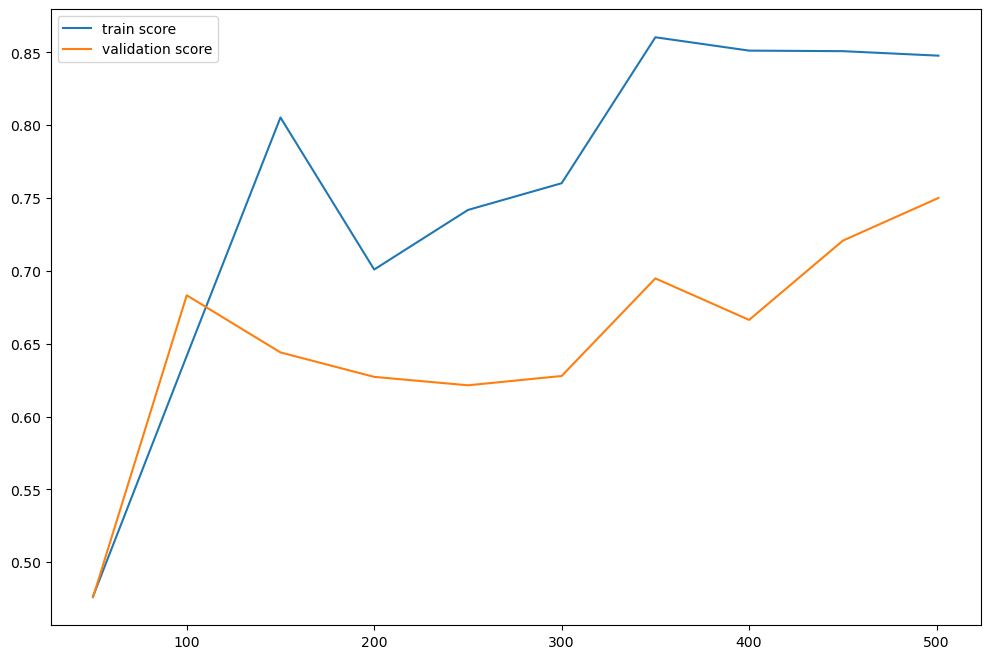

In [19]:
evaluation(grid.best_estimator_)

In [20]:
from sklearn.metrics import precision_recall_curve, recall_score

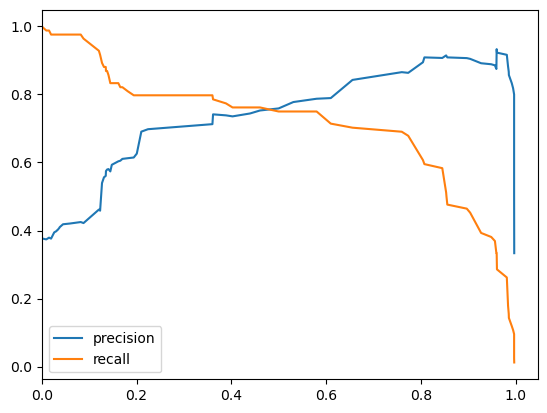

In [21]:
precision, recall, threshold = precision_recall_curve(y_test, grid.best_estimator_.predict_proba(X_test)[:, 1])
plt.plot(threshold, precision[:-1], label="precision")
plt.plot(threshold, recall[:-1], label="recall")
plt.xlim(0,)
plt.legend()

In [22]:
def model_final(model, X, threshold=0):
    return (model.predict_proba(X)[:, 1] > threshold).astype(int)

In [23]:
y_pred = model_final(grid.best_estimator_, X_test, threshold=0.5)

In [24]:
f1_score(y_test,y_pred)

0.7636363636363637

In [25]:
recall_score(y_test,y_pred)

0.75

In [26]:
data_test = pd.read_csv("test_titanic.csv")
df_test = data_test.copy()

<Axes: >

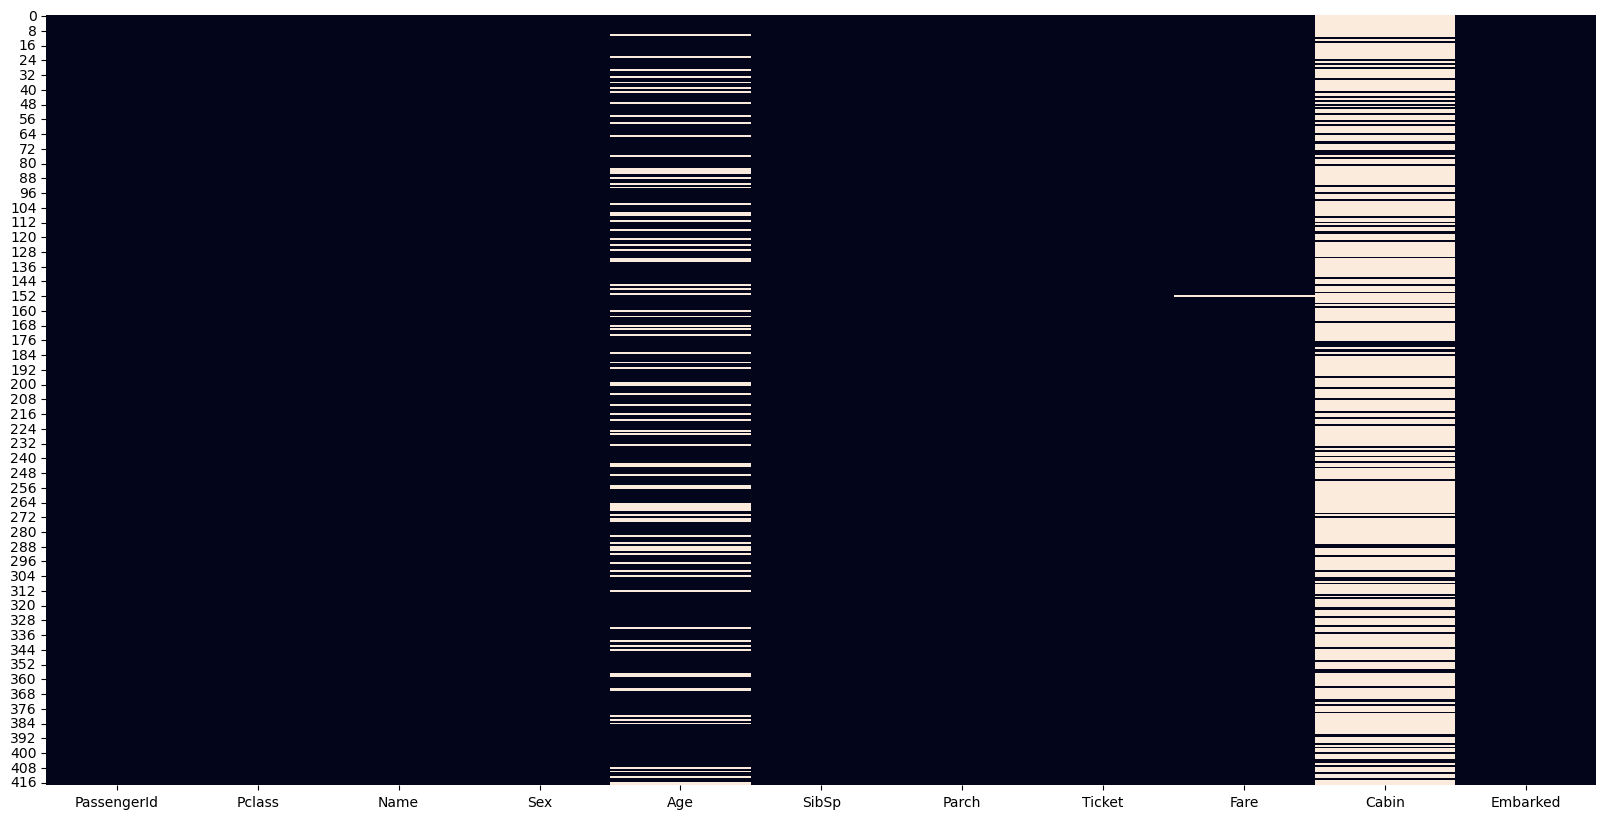

In [27]:
plt.figure(figsize=(20,10))
sns.heatmap(df_test.isna(),cbar=False)

In [28]:
df_test = df_test.drop(["Cabin", "Name", "Ticket"], axis=1)

In [29]:
df_testId = df_test["PassengerId"]
df_test = df_test.drop(["PassengerId"], axis=1)

In [30]:
y_pred_test = model_final(grid.best_estimator_, df_test, threshold=0.35)

In [31]:
df_test["Survived"] = y_pred_test
df_test['PassengerId'] = df_testId
df_final = df_test[["PassengerId", "Survived"]]

In [32]:
df_final

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [33]:
df_final.to_csv("predictions5.csv", index=False)